# Can Atoti Predict Baseball? How will the COVID Season Impact Baseball Stats?

## Introduction

Credit: The original version of this notebook was created by Neil Cosgrove and it's available on https://github.com/ncosgrov/atoti_baseball_analysis.  

Read more: https://medium.com/@neilcosgrove/can-atoti-predict-baseball-how-will-the-covid-season-impact-baseball-stats-ad9322e3b722

Baseball is a game built on statistics.  There seems to be a statistic for every possible combination and permutation of events that can happen in a game or a  season.  Fans enjoy comparing stats in a perpetual game of "who was the greatest (<i>fill in the blank</i>); creating matchups that span generations.  The availability of data analysis tool like atoti bring a whole new dimension (no pun intended) to these discussons allowing for endless analysis which <b><u> WARNING</u></b> can become addictive :-).

For a game that loves its statistics, the 2020 Covid shortened season presents a nightmare.  Instead of playing 162 games, the season will only be 60 games, no doubt setting up endless "what if" debates in future years in regards to players active in this season who just miss key milestones.

In this notebook, we decide to get a jump on the debate by looking at veterans who have diminishing season to make up those lost 102 games, focusing in on a specific example.

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=baseball" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover.png" alt="Try atoti"></a></div>

## Getting the atoti library

We will first start by importing support libraries and [atoti](https://docs.atoti.io/latest/installation.html).

In [1]:
import atoti as tt
import pandas as pd

## Importing The Data and Wrangling 

The dataset used comes from Sean Lahman's website at http://www.seanlahman.com/baseball-archive/statistics/. The work is licensed under a Creative Commons Attribution-ShareAlike 3.0 Unported License. This is a great site and has more types of Baseball stats than you can imagine.  For the purpose of this exercise, we will confine ourselve to Batting Statistics. For those more interested in the analaysis, you can skip to the <i> Create the Atoti Cube</i> section

### Player Information

We begin by importing the master table which has individual player information. 

In [2]:
pd.set_option("display.max_columns", None)
player_df = pd.read_csv(
    "http://data.atoti.io/notebooks/baseball/People.csv",
    usecols=[
        "playerID",
        "birthYear",
        "nameGiven",
        "nameLast",
        "nameFirst",
        "bats",
        "throws",
        "debut",
        "finalGame",
    ],
    parse_dates=["debut", "finalGame"],
    dtype={"birthYear": "Int64"},
)

In [3]:
player_df.head()

,playerID,birthYear,nameFirst,nameLast,nameGiven,bats,throws,debut,finalGame
0,aardsda01,1981,David,Aardsma,David Allan,R,R,2004-06-04,2015-08-23
1,aaronha01,1934,Hank,Aaron,Henry Louis,R,R,1954-04-13,1976-03-10
2,aaronto01,1939,Tommie,Aaron,Tommie Lee,R,R,1962-10-04,1971-09-26
3,aasedo01,1954,Don,Aase,Donald William,R,R,1977-07-26,1990-03-10
4,abadan01,1972,Andy,Abad,Fausto Andres,L,L,2001-10-09,2006-04-13


In [4]:
player_df.shape

(19878, 9)

In [5]:
player_df.dtypes

playerID             object
birthYear             Int64
nameFirst            object
nameLast             object
nameGiven            object
bats                 object
throws               object
debut        datetime64[ns]
finalGame    datetime64[ns]
dtype: object

We will do some data cleanup.  The dataset has a lot of late 19th century data that is missing values (not the datasets fault, just no one recorded the values at the time).

In [6]:
# Lets Clean up names
# Get Rid of Blank First and Given Names, records where we dont know when player started
player_df.dropna(subset=["nameFirst", "debut"], inplace=True)
player_df["nameGiven"].fillna("Unknown", inplace=True)

In [7]:
FullName = player_df["nameFirst"] + " " + player_df["nameLast"]
player_df.insert(4, "fullName", FullName)

In [8]:
player_df.head()

,playerID,birthYear,nameFirst,nameLast,fullName,nameGiven,bats,throws,debut,finalGame
0,aardsda01,1981,David,Aardsma,David Aardsma,David Allan,R,R,2004-06-04,2015-08-23
1,aaronha01,1934,Hank,Aaron,Hank Aaron,Henry Louis,R,R,1954-04-13,1976-03-10
2,aaronto01,1939,Tommie,Aaron,Tommie Aaron,Tommie Lee,R,R,1962-10-04,1971-09-26
3,aasedo01,1954,Don,Aase,Don Aase,Donald William,R,R,1977-07-26,1990-03-10
4,abadan01,1972,Andy,Abad,Andy Abad,Fausto Andres,L,L,2001-10-09,2006-04-13


Anticipating that in future analysis we may want to do some analysis where we compare players on "career years" rather than "calendar years" we create a dictionary of the years players debuted for use in the next table.

In [9]:
player_df["debutYear"] = pd.DatetimeIndex(player_df["debut"]).year
player_df.head()

,playerID,birthYear,nameFirst,nameLast,fullName,nameGiven,bats,throws,debut,finalGame,debutYear
0,aardsda01,1981,David,Aardsma,David Aardsma,David Allan,R,R,2004-06-04,2015-08-23,2004
1,aaronha01,1934,Hank,Aaron,Hank Aaron,Henry Louis,R,R,1954-04-13,1976-03-10,1954
2,aaronto01,1939,Tommie,Aaron,Tommie Aaron,Tommie Lee,R,R,1962-10-04,1971-09-26,1962
3,aasedo01,1954,Don,Aase,Don Aase,Donald William,R,R,1977-07-26,1990-03-10,1977
4,abadan01,1972,Andy,Abad,Andy Abad,Fausto Andres,L,L,2001-10-09,2006-04-13,2001


### Battling Information

OK, the Master table of player info is done, lets import the batting table and clean it up

In [10]:
battling_df = pd.read_csv(
    "http://data.atoti.io/notebooks/baseball/Batting.csv",
    dtype={
        "RBI": "Int64",
        "SB": "Int64",
        "CS": "Int64",
        "SO": "Int64",
        "IBB": "Int64",
        "HBP": "Int64",
        "SH": "Int64",
        "SF": "Int64",
        "GIDP": "Int64",
    },
)

In [11]:
battling_df.head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abercda01,1871,1,TRO,NaN,1,4,0,0,0,0,0,0,0,0,0,0,<NA>,<NA>,<NA>,<NA>,0
1,addybo01,1871,1,RC1,NaN,25,118,30,32,6,0,0,13,8,1,4,0,<NA>,<NA>,<NA>,<NA>,0
2,allisar01,1871,1,CL1,NaN,29,137,28,40,4,5,0,19,3,1,2,5,<NA>,<NA>,<NA>,<NA>,1
3,allisdo01,1871,1,WS3,NaN,27,133,28,44,10,2,2,27,1,1,0,2,<NA>,<NA>,<NA>,<NA>,0
4,ansonca01,1871,1,RC1,NaN,25,120,29,39,11,3,0,16,6,2,2,1,<NA>,<NA>,<NA>,<NA>,0


In [12]:
battling_df.shape

(107429, 22)

In [13]:
battling_df.rename(
    columns={
        "lgID": "League",
        "G": "Games",
        "AB": "At Bats",
        "R": "Runs",
        "H": "Hits",
        "2B": "Doubles",
        "3B": "Triples",
        "HR": "Homeruns",
        "RBI": "Runs Batted In",
        "SB": "Stolen Bases",
        "CS": "Caught Stealing",
        "BB": "Base on Balls",
        "SO": "Strikeouts",
        "IBB": "Intentional walks",
        "HBP": "Hit by pitch",
        "SH": "Sacrifice hits",
        "SF": "Sacrifice flies",
        "GIDP": "Grounded into double plays",
    },
    inplace=True,
)

In [14]:
battling_df.League.unique()

array([nan, 'NL', 'AA', 'UA', 'PL', 'AL', 'FL'], dtype=object)

In [15]:
# Cull down to just NL and Al Leagues
modern_league_names = ["NL", "AL"]
battling_df = battling_df.loc[battling_df["League"].isin(modern_league_names)].copy()
battling_df.League.unique()

array(['NL', 'AL'], dtype=object)

#### Add Career Season 

In [16]:
debutDict = dict(zip(player_df.playerID, player_df.debutYear))
battling_df["careerYear"] = battling_df["playerID"].map(debutDict)

In [17]:
battling_df["careerYear"] = battling_df["yearID"] - battling_df["careerYear"] + 1
battling_df["careerYear"] = battling_df["careerYear"].astype(pd.Int32Dtype())
battling_df.head()

,playerID,yearID,stint,teamID,League,Games,At Bats,Runs,Hits,Doubles,Triples,Homeruns,Runs Batted In,Stolen Bases,Caught Stealing,Base on Balls,Strikeouts,Intentional walks,Hit by pitch,Sacrifice hits,Sacrifice flies,Grounded into double plays,careerYear
738,addybo01,1876,1,CHN,NL,32,142,36,40,4,1,0,16,<NA>,<NA>,5,0,<NA>,<NA>,<NA>,<NA>,<NA>,6
739,allisar01,1876,1,LS1,NL,31,130,9,27,2,1,0,10,<NA>,<NA>,2,6,<NA>,<NA>,<NA>,<NA>,<NA>,6
740,allisdo01,1876,1,HAR,NL,44,163,19,43,4,0,0,15,<NA>,<NA>,3,9,<NA>,<NA>,<NA>,<NA>,<NA>,6
741,andrufr01,1876,1,CHN,NL,8,36,6,11,3,0,0,2,<NA>,<NA>,0,5,<NA>,<NA>,<NA>,<NA>,<NA>,1
742,ansonca01,1876,1,CHN,NL,66,309,63,110,9,7,2,59,<NA>,<NA>,12,8,<NA>,<NA>,<NA>,<NA>,<NA>,6


### Team Information

Team ID is deceptive, it is not as "human readable" as you would think, lets replace with franchise names (but note that these will be the current franchise name, i.e. Babe Ruth's Boston Braves will show that the team is the current Atlanta Braves)

Get Franchises and create a dictionary of Franchise ID to name 

In [18]:
franchises_df = pd.read_csv(
    "http://data.atoti.io/notebooks/baseball/TeamsFranchises.csv"
)

In [19]:
franchises_df.shape

(120, 4)

In [20]:
team_df = pd.read_csv(
    "http://data.atoti.io/notebooks/baseball/Teams.csv",
    usecols=["yearID", "lgID", "teamID", "franchID"],
)
team_df.shape

(2925, 4)

In [21]:
team_df = pd.merge(team_df, franchises_df, on=["franchID"])
team_df.shape

(2925, 7)

In [22]:
team_df.rename(columns={"franchName": "teamName"}, inplace=True)
team_df.head()

,yearID,lgID,teamID,franchID,teamName,active,NAassoc
0,1871,NaN,BS1,BNA,Boston Red Stockings,NaN,ATL
1,1872,NaN,BS1,BNA,Boston Red Stockings,NaN,ATL
2,1873,NaN,BS1,BNA,Boston Red Stockings,NaN,ATL
3,1874,NaN,BS1,BNA,Boston Red Stockings,NaN,ATL
4,1875,NaN,BS1,BNA,Boston Red Stockings,NaN,ATL


## Create the atoti Cube

In [23]:
session = tt.create_session()

In [24]:
player_table = session.read_pandas(
    player_df,
    keys=["playerID"],
    table_name="players",
)
player_table.head()

,birthYear,nameFirst,nameLast,fullName,nameGiven,bats,throws,debut,finalGame,debutYear
playerID,,,,,,,,,,
aardsda01,1981,David,Aardsma,David Aardsma,David Allan,R,R,2004-06-04,2015-08-23,2004
aaronha01,1934,Hank,Aaron,Hank Aaron,Henry Louis,R,R,1954-04-13,1976-03-10,1954
aaronto01,1939,Tommie,Aaron,Tommie Aaron,Tommie Lee,R,R,1962-10-04,1971-09-26,1962
aasedo01,1954,Don,Aase,Don Aase,Donald William,R,R,1977-07-26,1990-03-10,1977
abadan01,1972,Andy,Abad,Andy Abad,Fausto Andres,L,L,2001-10-09,2006-04-13,2001


In [25]:
batting_table = session.read_pandas(
    battling_df,
    keys=["playerID", "yearID", "teamID", "League"],
    table_name="batting",
)

batting_table.head()

stint  Games  At Bats  Runs  Hits  Doubles  \
League teamID playerID  yearID                                               
NL     CHN    addybo01  1876        1     32      142    36    40        4   
       LS1    allisar01 1876        1     31      130     9    27        2   
       HAR    allisdo01 1876        1     44      163    19    43        4   
       CHN    andrufr01 1876        1      8       36     6    11        3   
              ansonca01 1876        1     66      309    63   110        9   

                                Triples  Homeruns  Runs Batted In  \
League teamID playerID  yearID                                      
NL     CHN    addybo01  1876          1         0              16   
       LS1    allisar01 1876          1         0              10   
       HAR    allisdo01 1876          0         0              15   
       CHN    andrufr01 1876          0         0               2   
              ansonca01 1876          7         2              59   

                                Stolen Bases  Caught Stealing  Base on Balls  \
League teamID playerID  yearID                                                 
NL     CHN    addybo01  1876             NaN              NaN              5   
       LS1    allisar01 1876             NaN              NaN              2   
       HAR    allisdo01 1876             NaN              NaN              3   
       CHN    andrufr01 1876             NaN              NaN              0   
              ansonca01 1876             NaN              NaN             12   

                                Strikeouts  Intentional walks  Hit by pitch  \
League teamID playerID  yearID                                                
NL     CHN    addybo01  1876             0                NaN           NaN   
       LS1    allisar01 1876             6                NaN           NaN   
       HAR    allisdo01 1876             9                NaN           NaN   
       CHN    andrufr01 1876             5                NaN           NaN   
              ansonca01 1876             8                NaN           NaN   

                                Sacrifice hits  Sacrifice flies  \
League teamID playerID  yearID                                    
NL     CHN    addybo01  1876               NaN              NaN   
       LS1    allisar01 1876               NaN              NaN   
       HAR    allisdo01 1876               NaN              NaN   
       CHN    andrufr01 1876               NaN              NaN   
              ansonca01 1876               NaN              NaN   

                                Grounded into double plays  careerYear  
League teamID playerID  yearID                                          
NL     CHN    addybo01  1876                           NaN           6  
       LS1    allisar01 1876                           NaN           6  
       HAR    allisdo01 1876                           NaN           6  
       CHN    andrufr01 1876                           NaN           1  
              ansonca01 1876                           NaN           6

In [26]:
team_table = session.read_pandas(
    team_df,
    keys=["yearID", "lgID", "teamID"],
    table_name="teams",
)

team_table.head()

franchID              teamName active NAassoc
lgID teamID yearID                                              
N/A  BS1    1871        BNA  Boston Red Stockings    N/A     ATL
            1872        BNA  Boston Red Stockings    N/A     ATL
            1873        BNA  Boston Red Stockings    N/A     ATL
            1874        BNA  Boston Red Stockings    N/A     ATL
            1875        BNA  Boston Red Stockings    N/A     ATL

In [27]:
# atoti automatically maps columns with the same names between 2 datatables
batting_table.join(player_table)
batting_table.join(
    team_table, mapping={"League": "lgID", "yearID": "yearID", "teamID": "teamID"}
)

In [28]:
print("Number of results: ", player_table.shape)

Number of results:  {'rows': 19646, 'columns': 11}


### Let's create the cube and see what the tables look like

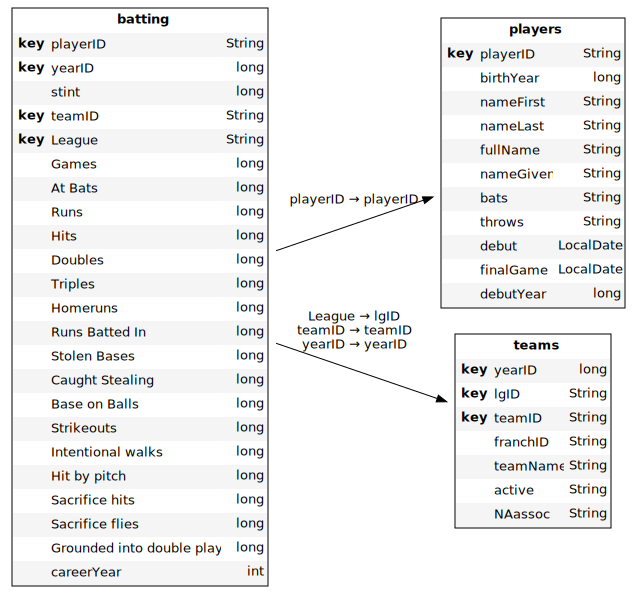

In [29]:
cube = session.create_cube(batting_table, name="Stats", mode="manual")
cube.schema

### Now Create Hierarchies and Measures

In [30]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

In [31]:
h["League"] = [batting_table["League"]]
h["Year"] = [batting_table["yearID"]]
h["Career Year"] = [batting_table["careerYear"]]
# players may have the same name but they will be unique by the playerId
h["Player"] = [player_table["playerID"], player_table["fullName"]]
h["Team"] = [team_table["teamName"]]
h["Debut"] = [player_table["debut"]]
h["Final Game"] = [player_table["finalGame"]]
# Lets Review the hierarchies
h

Hierarchies()

Let us create some measures. In 2020 Major League Baseball season, there are 60 games. We shall use this to project the players' performances.  
We shall see later on how an adjustment in the season length for 2020 will impact the players' performances.

In [32]:
m["2020 Season Length"] = 60
m["500 Home Runs"] = 500
m["Latest Season"] = tt.total(tt.agg.max(batting_table["yearID"]), h["Year"])
m["Latest Season"].formatter = "DOUBLE[####]"

In [33]:
cube.query(m["2020 Season Length"], m["500 Home Runs"], m["Latest Season"])

,2020 Season Length,500 Home Runs,Latest Season
0,60,500,2019


#### Player's stats

In [34]:
m["birthYear"] = tt.value(player_table["birthYear"])

m["PlayerAge"] = tt.where(
    l["playerID"] != None,
    m["Latest Season"] - m["birthYear"],
    None,
)

In [35]:
m["Career Length"] = tt.where(
    l["playerID"] != None,
    tt.agg.sum(
        tt.date_diff(l["debut"], l["finalGame"], unit="years"),
        scope=tt.scope.origin(l["playerID"]),
    ),
    None,
)

In [36]:
m["Games played"] = tt.where(
    l["playerID"] != None,
    tt.agg.sum(batting_table["Games"]),
    None,
)

In [37]:
m["Player Season At Bats"] = tt.where(
    l["playerID"] != None,
    tt.agg.sum(batting_table["At Bats"]),
    None,
)

In [38]:
session.visualize("Player's stats")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### Player's homerun stats

In [39]:
m["Homeruns"] = tt.agg.sum(batting_table["Homeruns"])
m["Homeruns Per Game"] = m["Homeruns"] / m["Games played"]
m["Player Total HR (Year)"] = tt.agg.sum(
    m["Homeruns"], scope=tt.scope.cumulative(l["yearID"])
)
m["Career HR"] = tt.agg.sum(m["Homeruns"], scope=tt.scope.cumulative(l["careerYear"]))

# projecting player's homerun
m["Median HR"] = tt.agg.mean(
    m["Homeruns Per Game"], scope=tt.scope.origin(l["playerID"])
)
m["Projected HR"] = tt.math.round(m["2020 Season Length"] * m["Median HR"])
m["Projected End Of Season Career HRs"] = (
    m["Player Total HR (Year)"] + m["Projected HR"]
)

In [40]:
session.visualize("Player's homerun stats")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### Player's hits stats

In [41]:
m["Hits"] = tt.agg.sum(batting_table["Hits"])
m["Hits Per Game"] = m["Hits"] / m["Games played"]
m["Player Total Hits (Year)"] = tt.agg.sum(
    m["Hits"], scope=tt.scope.cumulative(l["yearID"])
)
m["Career Hits"] = tt.agg.sum(m["Hits"], scope=tt.scope.cumulative(l["careerYear"]))

# projecting player's hits
m["Median Hits"] = tt.agg.mean(m["Hits Per Game"], scope=tt.scope.origin(l["playerID"]))
m["Projected Hits"] = tt.math.round(
    tt.math.round(m["2020 Season Length"] * m["Median Hits"])
)
m["Projected End Of Season Career Hits"] = (
    m["Player Total Hits (Year)"] + m["Projected Hits"]
)

In [42]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

## The Fun Stuff, the Analysis

So let's pose a basic question: who is being impacted by the COVID shortened Baseball season of 60 rather than 162 games?  Well, certainly everyone; a missed game is an opportunity to put something in the book for the future and even a non-Hall of Famer would like to get one more hit or one more homerun in their career.  However, certainly veteran players, which we will define as 10 years in the league, have less of a career remainder left to make up for lost 2020 opportunities

So let us look at players who have played over 10 years and are closing in on the respected 500 Home Run Mark 

In [43]:
session.visualize("Players over 10 Years in League with over 200 Home Runs")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Puts into perspective how tough getting 500 Home Runs is.  Pujols is already well past the post, Miguel Cabrera is in striking distance at 477. Nelson Cruz (age 40) and Edwin Encarnación (age 37)  have a steep climb to get there, probably needing  four excellent seasons; certainly losing 60% of their potential at bats this year may put it out of reach especially for Cruz who would likely have to stay healty and maintain his production till about 44.


In [44]:
session.visualize("Nelson Cruz (age 40) and Edwin Encarnación")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Let us now look at hits, focusing in on the mythical 3000 mark

In [45]:
session.visualize("Players over 10 Years in League with in top 25% of Career Hits")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Suzuki has retired (he shows as his last game was last year), Pujol is in.  Cano at age 38 and 430 hits outs was facing a tough challenge.  Looking at his career hit production which is declining, the shortened 2020 season may have put is out of reach. The fact that his hit production and games played crossed last season is not a good sign.

In [46]:
session.visualize("Robinson Cano Hit Production VS Career Years")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

However, the most interesting is Miguel Cabrera, looking at his 2019 stats as the close of 2019

In [47]:
session.visualize("Cabera End of 2019 Stats")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Cabrera is well within striking distance to joing  some excluive company the "500 HR/3000 hits club"! A feat attained by only 6 players in the history of Baseball.

In [48]:
session.visualize("500 HR/3000 hits club")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### What-if 2020 becomes a standard 162 game season?

Let's run a simulation to see what the impact of the shortened 2020 season would be assuming that Cabrera "plays to the back of his baseball card" defined as he attains his median hits and home run per game for the season. The base will be the now accepted 60 games season versus a standard 162 game season

In [49]:
# The default value is the current 60 games season
season_simulation = cube.create_parameter_simulation(
    "Impact 2020 Season Length Simulation",
    measure_name="Season length parameter",
    default_value=60,
    base_scenario_name="2020 60 Game Season",
)

In [50]:
# Use the original measure when the simulated measure is equal to the provided default value
m["Simulated 2020 Season Length"] = tt.where(
    m["Season length parameter"] != 60,
    m["Season length parameter"],
    m["2020 Season Length"],
)

In [51]:
season_simulation += ("Full Length 2020", 162)

Instead of using the measure `Simulated 2020 Season Length` to project the number of homeruns, we can update the formula to use the simulation parameter related measure - `Simulated 2020 Season Length`.

In [52]:
m["Projected HR"] = tt.math.round(m["Simulated 2020 Season Length"] * m["Median HR"])

In [53]:
session.visualize(
    "Full length 2020 - Impact on player's end of season career hit projection"
)

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

We can see Edwin Encarnaclon and Nelson Cruz goes closer to the 500 homeruns. The closest however is Miguel Cabrera.

<h3>What do Cabrera's projected Numbers look like in the 60 game COVID season versus a normal 162 Game Season?</h3>

In [54]:
session.visualize("Cabrera's projected performance - full length 2020")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### What happens when Covid season is followed by full length 2021?

So per the assumptions of this analysis, if 2020 was a full season,  having a "median year" Cabrera would not get him into the "500 HR/3000 hits club", but  he would be <u>very close</u>.  It would certainly not be outside the realm of possibility that if he had a better than average year he could find an extra 19 hits and 9 homeruns over the course of 162 games.  Even if he missed in 2020, getting those landmarks would seem very likely even if Cabrera had an off year in 2021.

The concern is that coming out of the shortened season, what would Cabrera's numbers look like if after a "median" full 162 game season followed a "median" Covid Shortened season?  Let's run another simulation, where we project a 60 game season followed by a 162 game season. 

In [55]:
season_simulation += ("Covid Season followed by Full Length 2021", 60 + 162)

In [56]:
session.visualize(
    "Cabrera's projected performance - Covid season followed by full length 2021"
)

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

So the COVID shortened Season turns Miguel Cabrera's highly likely induction into the "500 HR/3000 hits club" by the 2021 season under normal circumstanse into a far risky proposition, changing it from an optimistic "one season away" to a potential "three seasons" with all the risks that playing an additional three late career seasons entails.

We will have to see the results and if atoti disproves that "<i>You can’t predict baseball Suzyn</i>".

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=baseball" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover-try.png" alt="Try atoti"></a></div>